# Nonlinear Buckling Method Verification

We want to verify Nastran's nonlinear buckling method on a box beam model. We consider a box beam model with a rigid tip section and a concentrated load applied at the center of such section.

## Base model definition
### Geometry

In [15]:
AR = 9 # aspect ratio - b/w
w = 1e3   # width [mm]
b = AR*w  # span [mm]
non_dimensional_height = 0.2     # h/w
h = w*non_dimensional_height     # box height [mm]
non_dimensional_thickness = 1/50 # t/h
t = h*non_dimensional_thickness  # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.1f} m\n- semispan: {b/2/1e3:.1f} m\n- height: {h/1e3:.1f} m\n- wall thickness: {t:.1f} mm')

Box beam dimensions:
- width: 1.0 m
- semispan: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm


### Material

In [16]:
rho = 2780e-12 # density [ton/mm^3]
E = 73.1e3 # Young's modulus [MPa]
nu = 0.3 # Poisson's ratio

### Mesh
Simple box beam without ribs.

In [17]:
from resources import box_beam_utils
element_size = 23 # [mm]
box_beam_base_input, nodes_id_array, edge_indices, elements_id_array = box_beam_utils.create_mesh(E, nu, rho, t, w, b, h, element_size)
print(box_beam_base_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.nodes
  GRID     : 19600

bdf.elements
  CQUAD4   : 19500

bdf.properties
  PSHELL   : 1

bdf.materials
  MAT1     : 1




### Boundary condition and load
Boundary condition: clamped at the root.

In [18]:
# Add SPC1 card to bulk data
constraint_set_id = 1
root_nodes_ids = list(nodes_id_array[0,0:-2])
box_beam_base_input.add_spc1(constraint_set_id, '123456', root_nodes_ids)
# Select single point constraint in case control section
box_beam_base_input.create_subcases(0)
box_beam_base_input.case_control_deck.subcases[0].add_integer_type('SPC', constraint_set_id)

subcase=0 already exists...skipping


Applied load: concentrated force applied at the center of the tip section, which is made rigid.

In [19]:
import numpy as np
# Add master node of tip section
master_node_id = np.amax(nodes_id_array)+1
box_beam_base_input.add_grid(master_node_id, [w/2, b/2, 0.])
# Add RBE2 element to make tip section rigid
rbe2_element_id = len(box_beam_base_input.elements)+1
tip_nodes_ids = list(nodes_id_array[-1,0:-2])
box_beam_base_input.add_rbe2(rbe2_element_id, master_node_id, '123456', tip_nodes_ids)
# Apply concentrated force to master node
force_set_id = constraint_set_id+1
force_magnitude = 1. # [N]
force_direction = [0., 0., 1.]
box_beam_base_input.add_force(sid=force_set_id, node=master_node_id, mag=force_magnitude, xyz=force_direction)

FORCE          2   19601              1.      0.      0.      1.

Setup nonlinear analysis solution sequence.

In [20]:
# Assign solution sequence
box_beam_base_input.sol = 106
# Add parameter for large displacement effects
box_beam_base_input.add_param('LGDISP', [1])
# Define general parameters for the nonlinear iteration strategy
nlparm_id = 1
box_beam_base_input.add_nlparm(nlparm_id=nlparm_id, kmethod='ITER', kstep=1, int_out='YES', conv='PW', eps_p=1e-2, eps_w=1e-2)
# Define parameters for the arc-length method
box_beam_base_input.add_nlpci(nlpci_id=nlparm_id, Type='CRIS', desiter=12, minalr=.25, maxalr=4.)
# Add NLPARM id to the control case commands
box_beam_base_input.case_control_deck.subcases[0].add_integer_type('NLPARM', nlparm_id)

Setup buckling analysis parameters.

In [21]:
box_beam_base_input.add_param('BUCKLE', [2])
eigrl_set_id = force_set_id+1
box_beam_base_input.add_eigrl(sid=eigrl_set_id, v1=0., nd=1)
box_beam_base_input.case_control_deck.subcases[0].add_integer_type('METHOD', eigrl_set_id)

Set output files.

In [22]:
# Add PARAM card to store results in a op2 file
box_beam_base_input.add_param('POST', [1])
# Set defaults for output files
box_beam_base_input.case_control_deck.subcases[0].add('ECHO', 'NONE', [], 'STRING-type') # request neither sorted nor unsorted Bulk Data to be printed
box_beam_base_input.case_control_deck.subcases[0].add_result_type('DISPLACEMENT', 'ALL', ['PLOT']) # store displacement data of all nodes in the op2 file
box_beam_base_input.case_control_deck.subcases[0].add_result_type('OLOAD', 'ALL', ['PLOT']) # store form and type of applied load vector

Define subcases.

In [23]:
from resources import pynastran_utils
box_beam_verification_input = box_beam_base_input.__deepcopy__({})
load_magnitudes = np.linspace(1, 3200, 10)
np.set_printoptions(precision=0, suppress=True)
print(f'Applied loads [N]: {load_magnitudes}')
for i, scale_factor in enumerate(load_magnitudes):
    load_set_id = 11+i
    box_beam_verification_input.add_load(sid=load_set_id, scale=1., scale_factors=[scale_factor], load_ids=[force_set_id])
    pynastran_utils.create_static_load_subcase(bdf_object=box_beam_verification_input, subcase_id=i+1, load_set_id=load_set_id)

Applied loads [N]: [   1.  356.  712. 1067. 1423. 1778. 2134. 2489. 2845. 3200.]


Run analysis.

In [24]:
import os
# Define name of analysis directory
analysis_directory_name = '06_Nonlinear_Buckling_Method_Verification'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
# Run analysis
input_filename = 'nonlinear_buckling_verification'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=box_beam_verification_input, bdf_filename=input_filename, run_flag=True)

Read load displacement data and nonlinear buckling load for each load case.

In [25]:
# Import function to read op2 file
from pyNastran.op2.op2 import read_op2
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=False)
# Find load and displacement history
load_steps, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=master_node_id)
# Find nonlinear buckling loads and critical buckling factors
nonlinear_buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=os.path.join(analysis_directory_path, input_filename + '.f06'), op2_object=op2_output)

Plot results

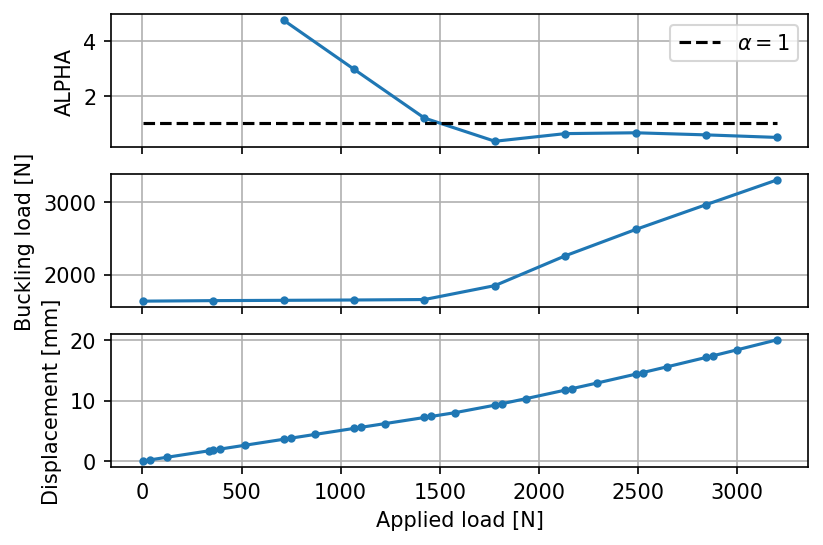

In [26]:
import matplotlib.pyplot as plt  # plotting library
# Set default dpi of figures
plt.rcParams['figure.dpi'] = 150
# Collect loads and displacements of interest
load_history = np.concatenate([loads[subcase_id][:,2] for subcase_id in loads])
displacement_history = np.concatenate([displacements[subcase_id][:,2] for subcase_id in displacements])
# Create figure with subplots
fig, axs = plt.subplots(nrows=3, ncols=1, sharex='all')
# Plot critical buckling factors vs applied loads
axs[0].plot(load_magnitudes[2:], critical_buckling_factors[2:], '.-')
reference, = axs[0].plot(load_magnitudes, [1]*len(load_magnitudes), '--k', label='$\\alpha=1$')
# Plot nonlinear buckling loads vs applied loads
axs[1].plot(load_magnitudes, nonlinear_buckling_loads, '.-')
# Plot load-displacement diagram
axs[2].plot(load_history[load_history>=load_magnitudes[0]], displacement_history[load_history>=load_magnitudes[0]], '.-')
# Set plot appearance
axs[0].set_ylabel('ALPHA')
axs[0].grid(visible=True)
axs[0].legend(handles=[reference])
axs[1].set_ylabel('Buckling load [N]')
axs[1].grid(visible=True)
axs[2].set_xlabel('Applied load [N]')
axs[2].set_ylabel('Displacement [mm]')
axs[2].grid(visible=True)
# Show plot
plt.show()

Let's zoom in where applied load vs buckling load curve changes slope.

In [27]:
# Define applied loads
load_magnitudes = np.linspace(1400, 1800, 10)
print(f'Applied loads [N]: {load_magnitudes}')
for i, scale_factor in enumerate(load_magnitudes):
    load_set_id = 11+i
    box_beam_verification_input.load_combinations[load_set_id][0].scale_factors = [scale_factor]
# Run analysis
input_filename = 'nonlinear_buckling_verification_zoomed'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=box_beam_verification_input, bdf_filename=input_filename, run_flag=True)

Applied loads [N]: [1400. 1444. 1489. 1533. 1578. 1622. 1667. 1711. 1756. 1800.]


Plot results

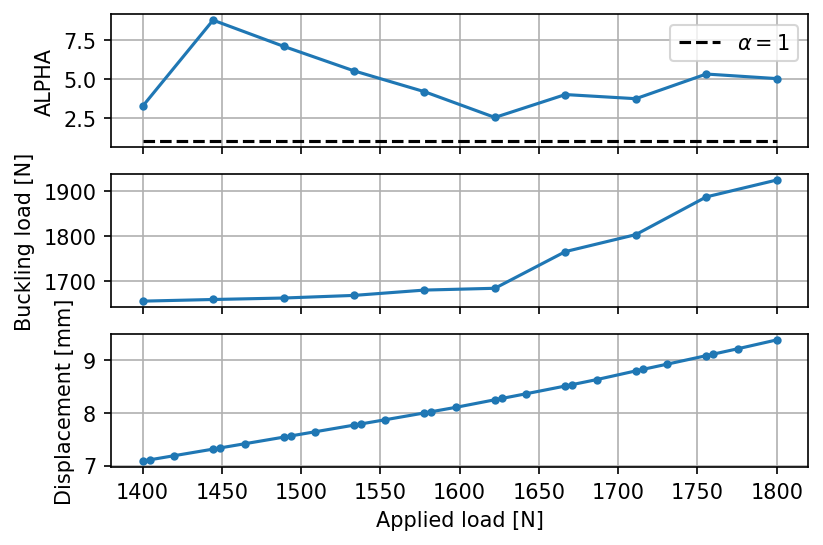

In [28]:
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=False)
# Find load and displacement history
load_steps, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=master_node_id)
# Find nonlinear buckling loads and critical buckling factors
nonlinear_buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=os.path.join(analysis_directory_path, input_filename + '.f06'), op2_object=op2_output)
# Collect loads and displacements of interest
load_history = np.concatenate([loads[subcase_id][:,2] for subcase_id in loads])
displacement_history = np.concatenate([displacements[subcase_id][:,2] for subcase_id in displacements])
# Create figure with subplots
fig, axs = plt.subplots(nrows=3, ncols=1, sharex='all')
# Plot critical buckling factors vs applied loads
axs[0].plot(load_magnitudes, critical_buckling_factors, '.-')
reference, = axs[0].plot(load_magnitudes, [1]*len(load_magnitudes), '--k', label='$\\alpha=1$')
# Plot nonlinear buckling loads vs applied loads
axs[1].plot(load_magnitudes, nonlinear_buckling_loads, '.-')
# Plot load-displacement diagram
axs[2].plot(load_history[load_history>=load_magnitudes[0]], displacement_history[load_history>=load_magnitudes[0]], '.-')
# Set plot appearance
axs[0].set_ylabel('ALPHA')
axs[0].grid(visible=True)
axs[0].legend(handles=[reference])
axs[1].set_ylabel('Buckling load [N]')
axs[1].grid(visible=True)
axs[2].set_xlabel('Applied load [N]')
axs[2].set_ylabel('Displacement [mm]')
axs[2].grid(visible=True)
# Show plot
plt.show()

Let's apply a load of 1800 N and monitor the definiteness of the tangent stiffness matrix.

In [29]:
box_beam_tangent_stiffness_matrix_input = box_beam_base_input.__deepcopy__({})
box_beam_tangent_stiffness_matrix_input.executive_control_lines[1:1] = ['include \'' + os.path.join(os.pardir, os.pardir, 'resources', 'kllrh_lowest_eigv.dmap') + '\'']  # include DMAP sequence
nlparm_id = 2
box_beam_tangent_stiffness_matrix_input.add_nlparm(nlparm_id, ninc=200, kmethod='ITER', kstep=1, max_iter=25, conv='PUV', int_out='YES', eps_p=1e-3, eps_u=1e-3, max_bisect=10)
box_beam_tangent_stiffness_matrix_input.add_nlpci(nlparm_id, Type='CRIS', minalr=.01, maxalr=2., desiter=2, mxinc=1000)
box_beam_tangent_stiffness_matrix_input.case_control_deck.subcases[0].params['NLPARM'][0] = nlparm_id
force_magnitude = 1800
box_beam_tangent_stiffness_matrix_input.loads[force_set_id][0].mag = force_magnitude
first_subcase_id = 1
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_tangent_stiffness_matrix_input, subcase_id=first_subcase_id, load_set_id=force_set_id)
# Define name of analysis directory
input_filename = 'tangent_stiffness_matrix'
# Run analysis
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=box_beam_tangent_stiffness_matrix_input, bdf_filename=input_filename, run_flag=True)

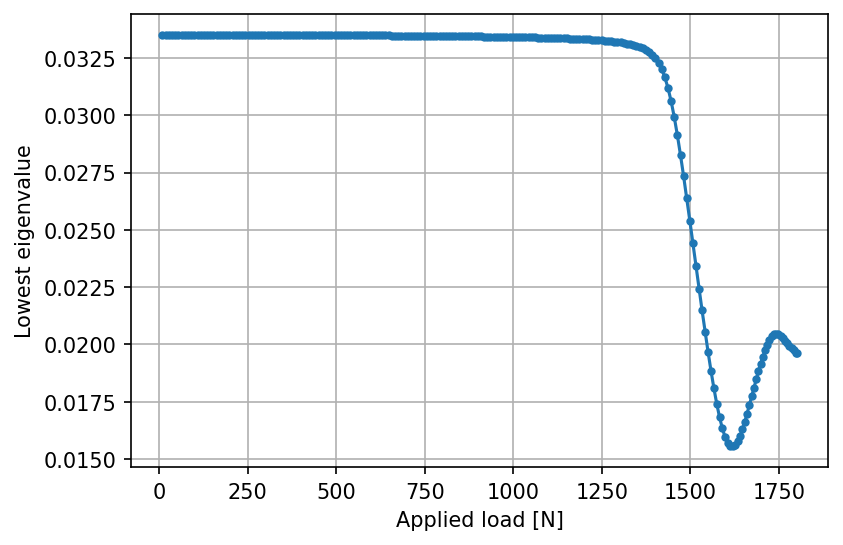

In [30]:
# Read OP2 file and find applied load history
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=False)
_, load_history, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output)
applied_load_history = [*load_history.values()][0][:,2]
# Read the lowest eigenvalue of KLLRH matrices from f06 file
f06_filepath = os.path.join(analysis_directory_path, input_filename + '.f06')  # path to .f06 file
lowest_eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)
# Create new figure and plot load history vs lowest eigenvalues
_, ax = plt.subplots()
ax.plot(applied_load_history, lowest_eigenvalues, '.-')
plt.xlabel('Applied load [N]')
plt.ylabel('Lowest eigenvalue')
plt.grid()
plt.show()